<h1><center>Part A: Classification Problem</center></h1>

This project aims at building neural networks to classify the Cardiotocography dataset containing measurements of fetal heart rate (FHR) and uterine contraction (UC) features as either “Normal (N)”, “Suspect (S)” or ”Pathological (P)”.

## Loading dependencies

In [1]:
import time
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

np.random.seed(10)
tf.random.set_seed(10)

## Pre-processing data

1. Load data from CSV file using genfromtxt
2. Remove nan row, and delete first output column
3. Split data using train_test_split
4. Scale data using min-max scaling
5. Subtract 1 from output for ease of computation

In [2]:
# Loading the data
data = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
data = data[1:] # Remove nan row
X, y = data[0:, :21], data[0:,-1].astype(int)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

# Scaling the data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert to 0,1,2
y_train = y_train-1
y_test = y_test-1

## Creating the main K-Folds function

This function is used throughout the notebook. It takes in model, batch size and epochs as parameters, and trains, compiles and fits the passed model, while also performing K-Folds Cross Validation using sklearn's StratifiedKFold() function. This effective modularization of code saves a lot of time later.

In [3]:
with tf.device('/CPU:0'):

  # Setting the parameters
  LEARNING_RATE = 0.01
  OPTIMIZER = SGD(learning_rate=LEARNING_RATE)
  LOSS_TYPE = SparseCategoricalCrossentropy()
  METRICS = ["accuracy"]

  def kFoldsTrain(model, batch_size, epochs):
      kf = StratifiedKFold(5, shuffle=True, random_state=42) #For 5-folds 
      
      #Defining parameters to keep track of current fold number, accuracy and time taken per epoch
      fold = 0
      fold_accuracies = []
      fold_time = []
      
      #Training the model using kf.split and saving fold timing ans accuracy information
      for train, test in kf.split(X_train, y_train):
          fold += 1
          print(f"Fold #{fold} currently running... ")
          
          # Splitting the data
          fold_X_train = X_train[train]
          fold_y_train = y_train[train]
          fold_X_test = X_train[test]
          fold_y_test = y_train[test]
          
          fold_model = tf.keras.models.clone_model(model)
          fold_model.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)

          start_time = time.time()
          history = fold_model.fit(fold_X_train, 
                              fold_y_train, 
                              validation_data=(fold_X_test, fold_y_test),
                              batch_size=batch_size, 
                              epochs=epochs, 
                              verbose=0)
          training_time = time.time() - start_time

          fold_accuracies.append(history.history["val_accuracy"])
          fold_time.append(training_time/epochs)

          fold_accuracy = history.history["val_accuracy"][epochs-1]
      return fold_accuracies, fold_time

In [4]:
# For getting the average validation accuracies vs. epoch across folds
def get_average_accuracy(accuracies):
  return np.mean(np.array(accuracies), axis = 0)

In [5]:
# For getting the average time taken to train
def get_average_time(times):
  return sum(times)/len(times)

## Experiments



# Q1) Designing a simple feedforward neural network

This question requires us to create a simple feedforward neural network with the following layers :- 
-	An input layer
-	One hidden layer of 10 neurons, with ReLU activation function 
-	An output softmax layer


These layers have the following specifications for parameters :-
-	A learning rate (α) of 0.01
-	A weight decay parameter (β) of 10^(-6)
-	A batch size of 32


In [6]:
with tf.device('/CPU:0'):

  # Defining the model
  q1_model = Sequential([
              Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
              Dense(units=3, activation="softmax")
          ])

  # Training the model
  q1_epochs = 5000
  q1_batch_size = 32

  q1_model.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)

  q1_history = q1_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=q1_batch_size, epochs=q1_epochs, verbose=0)

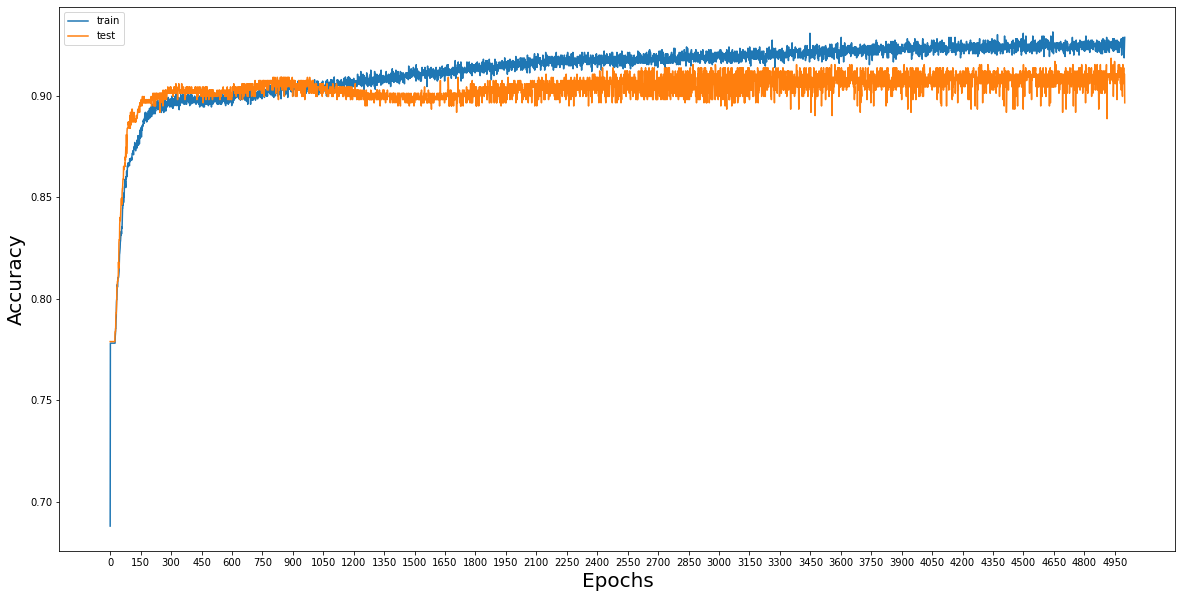

In [7]:
# 1(a) - Plotting train and test set accuracies vs epochs
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, q1_epochs+1, 150.0))

plt.plot(q1_history.history["accuracy"], label="train")
plt.plot(q1_history.history["val_accuracy"], label="test")

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)

plt.legend()
plt.show()

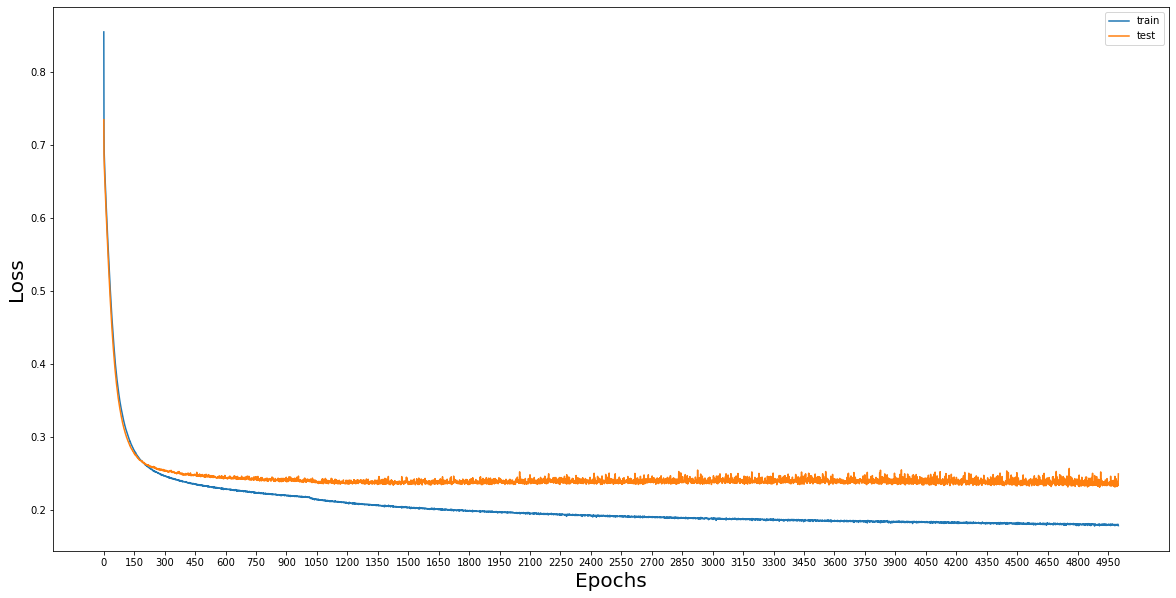

In [8]:
# Plotting train and test set loss vs epochs
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, q1_epochs+1, 150.0))

plt.plot(q1_history.history["loss"], label="train")
plt.plot(q1_history.history["val_loss"], label="test")

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)

plt.legend()
plt.show()

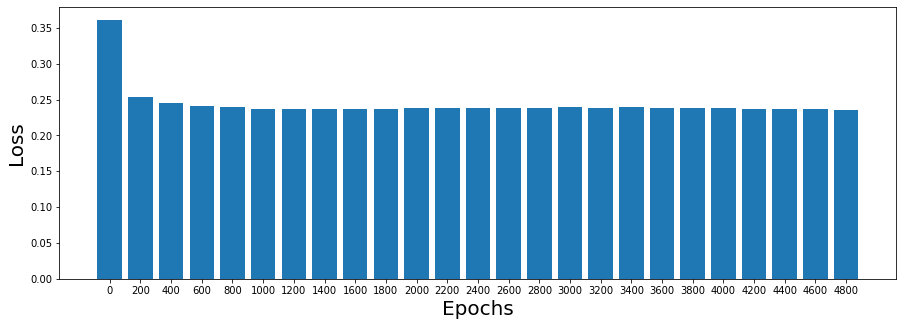

In [9]:
# Creating the dictionary for test losses every 200 epochs
loss_dict = {}
for epoch in range(0, 5000, 200):
  loss_dict[epoch] = sum(q1_history.history['val_loss'][epoch:epoch+199])/200

# Plotting loss vs 200 epochs
plt.figure(figsize=(15,5))
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.bar(range(len(loss_dict)), list(loss_dict.values()), align='center');
plt.xticks(range(len(loss_dict)), list(loss_dict.keys()));

It is clear from the graph that the sharpest drop in loss takes place before epoch 250, after which the loss starts to stagnate. Although the train loss goes down slowly, but consistently with epochs (even till epoch 5000), the test loss stagnates. Thus, there is little merit in training data after epoch 500 (an additional 300 epochs are added to account of variational errors).

In [10]:
EPOCHS = 500

# Q2) Finding the optimal batch size

The main objective of this question is to find the optimal batch size by training the neural network and evaluating the performances for different batch sizes :  [4,8,16,32,64]


In [11]:
# Defining the search space
batch_sizes = [4,8,16,32,64]

q2_model = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax")
        ])

avg_batch_accuracies = {}
avg_batch_times = {}

for current_batch_size in batch_sizes:
    print(f"Folds for Batch Size {current_batch_size} :-")
    q2_model_copy = tf.keras.models.clone_model(q2_model)
    fold_accuracies, fold_times = kFoldsTrain(q2_model_copy, current_batch_size, EPOCHS)
    
    avg_batch_accuracies[current_batch_size] = get_average_accuracy(fold_accuracies)
    avg_batch_times[current_batch_size] = get_average_time(fold_times)

Folds for Batch Size 4 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Batch Size 8 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Batch Size 16 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Batch Size 32 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Batch Size 64 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 


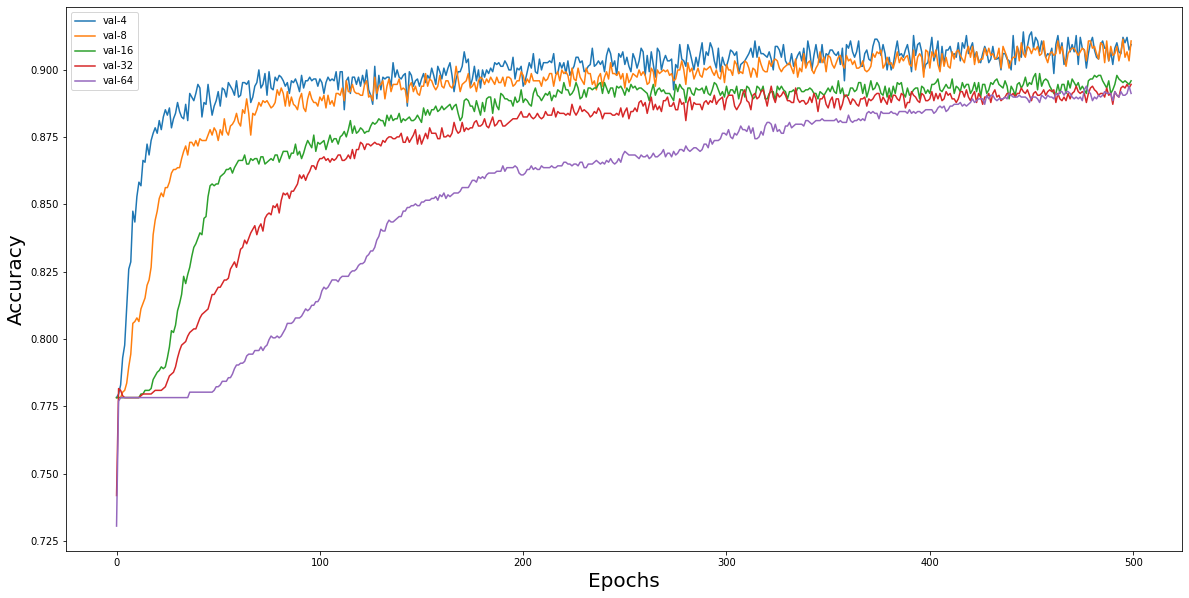

In [12]:
# Plotting accuracy vs epoch for each batch size

plt.figure(figsize=(20,10))
for current_batch_size, accuracy in avg_batch_accuracies.items():
    plt.plot(accuracy, label=f"val-{current_batch_size}")

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.legend()
plt.show()

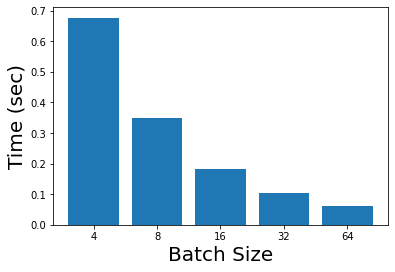

In [13]:
# Plotting training time per epoch vs batch size
plt.xlabel('Batch Size', fontsize=20)
plt.ylabel('Time (sec)', fontsize=20)

plt.bar(range(len(avg_batch_times)), list(avg_batch_times.values()), align='center');
plt.xticks(range(len(avg_batch_times)), list(avg_batch_times.keys()));

As we can see, as batch size increases, the time taken to train the model decreases linearly.


[0.9092581391334533, 0.9106071829795838, 0.895817220211029, 0.8944817304611206, 0.891126024723053]


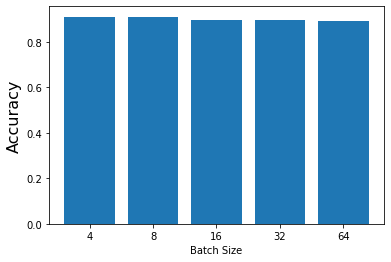

In [14]:
# Plot average validation accuracy for each batch size
batch_accuracies = [accuracies[EPOCHS-1] for accuracies in avg_batch_accuracies.values()]

print(batch_accuracies)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy', fontsize=16)
plt.bar(range(len(avg_batch_accuracies.keys())), batch_accuracies, align='center');
plt.xticks(range(len(avg_batch_accuracies.keys())), avg_batch_accuracies.keys());

Thus, a batch size of 8 has the highest validation accuracy, and only takes 50% if the training time required by the batch size of 4. It is thus advisable to continue the rest of the experiment with a batch size of 8.

In [15]:
BATCH_SIZE = 8

In [16]:
# Training on optimal batch size
optimal_q2_model = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax")
        ])


optimal_q2_model.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
history_2 = optimal_q2_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

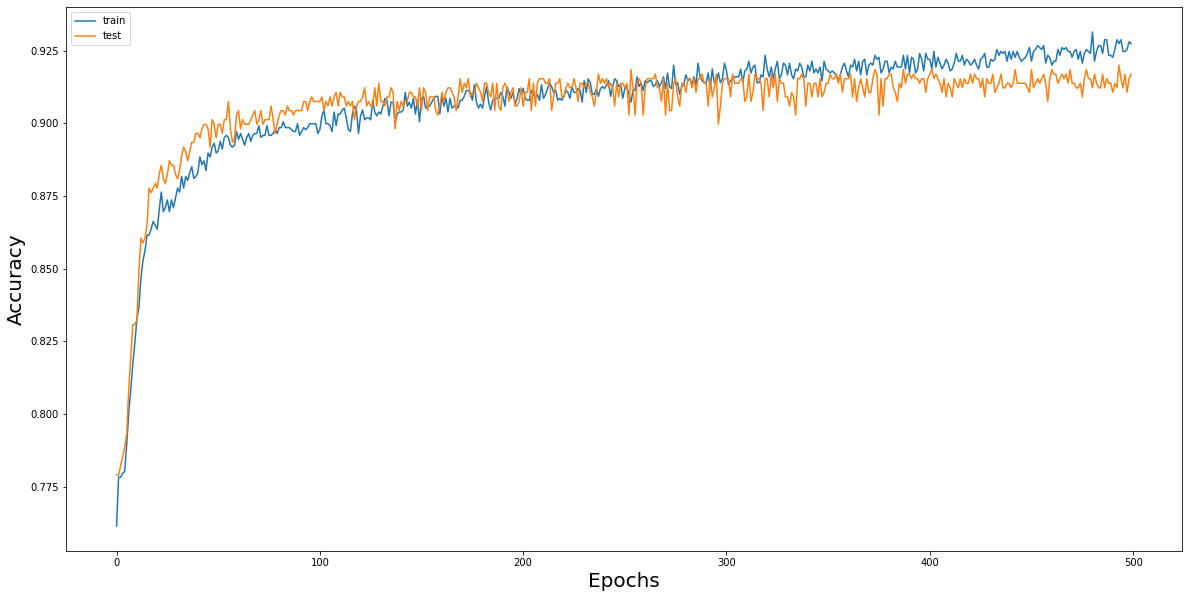

In [17]:
# Plotting train and test accuracy

plt.figure(figsize=(20,10))

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)

plt.plot(history_2.history["accuracy"], label="train")
plt.plot(history_2.history["val_accuracy"], label="test")

plt.legend()
plt.show()

# Q3) Finding the optimal number of neurons

The main objective of this question is to find the optimal number of hidden layer neurons by training the neural network and evaluating the performances for different number of hidden neurons : [5,10,15,20,25]



In [18]:
model_sizes = [5,10,15,20,25]
avg_model_size_accuracies = {}

for current_model_size in model_sizes:
    print(f"Folds for Neuron Count {current_model_size} :-")
    q3_model = Sequential([
            Dense(units=current_model_size, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax")
        ])
    fold_accuracies, _ = kFoldsTrain(q3_model, BATCH_SIZE, EPOCHS)
    
    avg_model_size_accuracies[current_model_size] = get_average_accuracy(fold_accuracies)

Folds for Neuron Count 5 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Neuron Count 10 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Neuron Count 15 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Neuron Count 20 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Neuron Count 25 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 


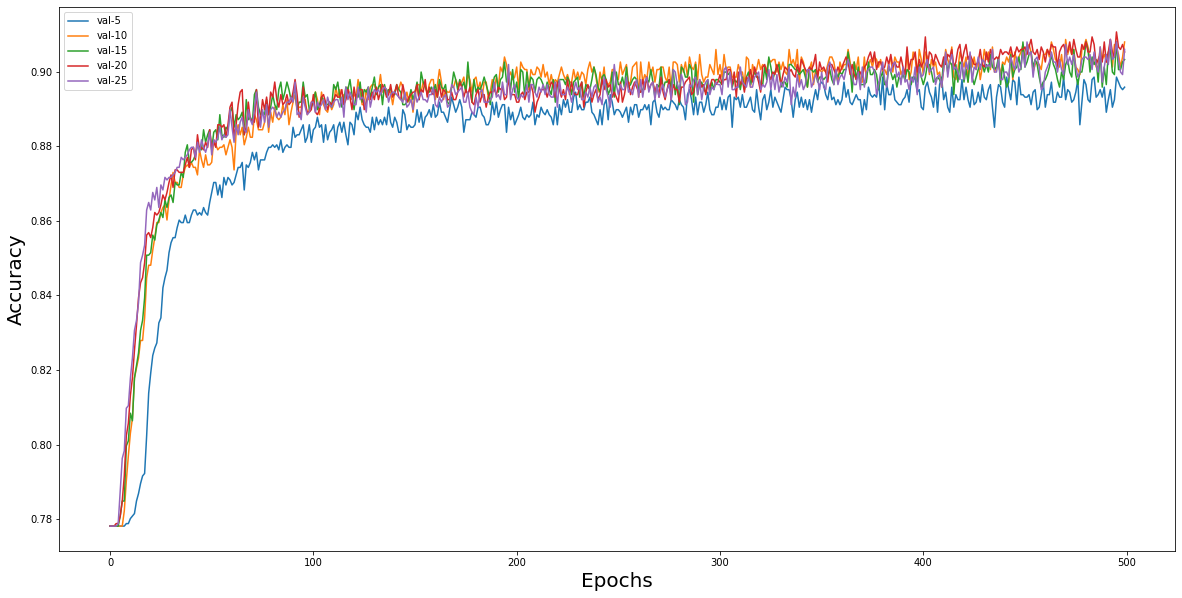

In [19]:
# Plotting accuracies vs epoch for each neuron count

plt.figure(figsize=(20,10))
for current_model_size, accuracy in avg_model_size_accuracies.items():
    plt.plot(accuracy, label=f"val-{current_model_size}")

plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.legend()
plt.show()

[0.89580819606781, 0.9079068064689636, 0.9032201170921326, 0.9052380800247193, 0.9059001803398132]


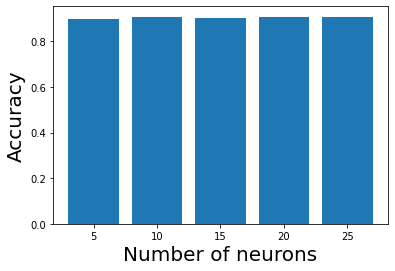

In [20]:
# Plot bar graph of accuracy vs neuron count
current_model_size = [accuracies[EPOCHS-1] for accuracies in avg_model_size_accuracies.values()]

print(current_model_size)

plt.xlabel('Number of neurons', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.bar(range(len(avg_model_size_accuracies.keys())), current_model_size, align='center');
plt.xticks(range(len(avg_model_size_accuracies.keys())), avg_model_size_accuracies.keys());

As the numbers of neurons in a hidden layer increase, the layer’s ability to learn more complex functions increases. Therefore, as we increase the number of neurons from 5 to 10, the validation accuracy increases. However, it can be seen that validation accuracy decreases as we go from 10 to 15 neurons. Increasing the number of hidden units and/or layers may lead to overfitting because it will make it easier for the neural network to memorize the training set but that does not generalize to unseen data. Thus, a hidden neuron layer size of 10 is taken for the rest of this experiment.


In [21]:
NUM_NEURONS = 10

In [23]:
# Training on optimal neuron count

q3_model_optimal = Sequential([
            Dense(units=NUM_NEURONS, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax", kernel_regularizer=l2(10**(-6)))
        ])

q3_model_optimal.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
history_3 = q3_model_optimal.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

print(f"Testing accuracy: {history_3.history['val_accuracy'][EPOCHS-1]}")

Testing accuracy: 0.9122257232666016


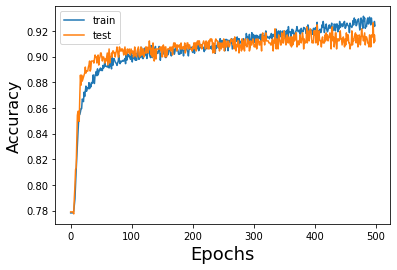

In [24]:
# Plotting train and test accuracy
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history_3.history["accuracy"], label="train")
plt.plot(history_3.history["val_accuracy"], label="test")
plt.legend()
plt.show()

# Q4) Finding the optimal decay parameter

The main objective of this question is to find the optimal decay parameter by training the neural network and evaluating the performances for different decay parameters : [0, 10<sup>-3</sup>, 10<sup>-6</sup>, 10<sup>-9</sup>, 10<sup>-12</sup>]


In [25]:
decay_sizes = [0,10**(-3),10**(-6),10**(-9),10**(-12)]
avg_decay_val_accuracies = {}

for current_decay in decay_sizes:
    print(f"Folds for Decay Parameter {current_decay} :-")
    q4_model = Sequential([
            Dense(units=NUM_NEURONS, activation="relu", kernel_regularizer=l2(current_decay)),
            Dense(units=3, activation="softmax")
        ])
    fold_accuracies, _ = kFoldsTrain(q4_model, BATCH_SIZE, EPOCHS)
    
    avg_decay_val_accuracies[current_decay] = get_average_accuracy(fold_accuracies)

Folds for Decay Parameter 0 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Decay Parameter 0.001 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Decay Parameter 1e-06 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Decay Parameter 1e-09 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 
Folds for Decay Parameter 1e-12 :-
Fold #1 currently running... 
Fold #2 currently running... 
Fold #3 currently running... 
Fold #4 currently running... 
Fold #5 currently running... 


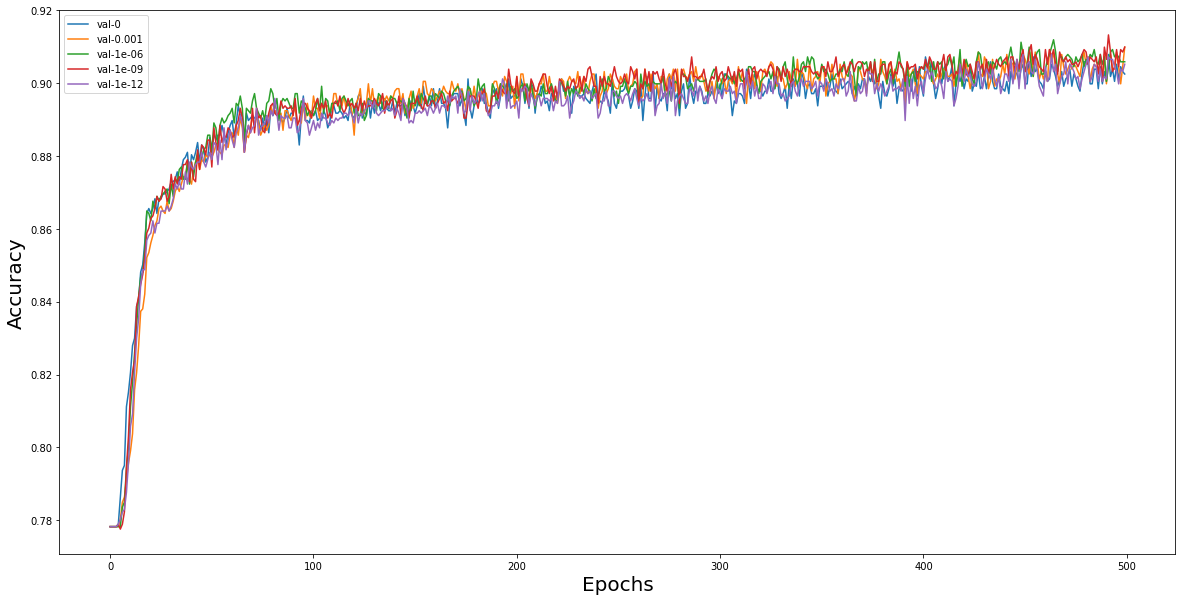

In [26]:
# Plotting accuracy vs epoch for each decay parameter

plt.figure(figsize=(20,10))

for current_decay, current_accuracy in avg_decay_val_accuracies.items():
    plt.plot(current_accuracy, label=f"val-{current_decay}")

plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.legend()
plt.show()

[0.9025421977043152, 0.9099337816238403, 0.9059137225151062, 0.9099315285682679, 0.9052290320396423]


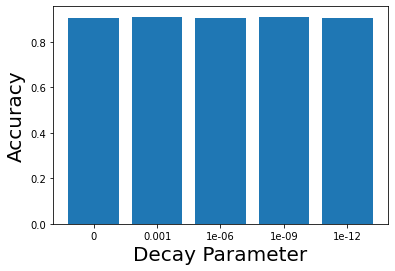

In [27]:
# Plotting accuracies for each decay parameter
current_decay_val = [accuracies[EPOCHS-1] for accuracies in avg_decay_val_accuracies.values()]

print(current_decay_val)

plt.xlabel('Decay Parameter', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.bar(range(len(avg_decay_val_accuracies.keys())), current_decay_val, align='center');
plt.xticks(range(len(avg_decay_val_accuracies.keys())), avg_decay_val_accuracies.keys());

By applying L2 regularization on our cost function, we penalize the model for having high weight values and thus prevent the model from overfitting the training data. Here, the decay parameter (λ) is the parameter that must be optimized. 

As it can be seen from the graphs, since the λ = 10<sup>-3</sup> gives the highest cross-validation accuracy. Thus, a decay parameter of 10<sup>-9</sup> is taken for the rest of this experiment.


In [28]:
DECAY_PARAMETER = 10**(-3)

In [29]:
# Training on optimal decay parameter

q4_model_optimal = Sequential([
            Dense(units=NUM_NEURONS, activation="relu", kernel_regularizer=l2(DECAY_PARAMETER)),
            Dense(units=3, activation="softmax")
        ])

q4_model_optimal.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
history_4 = q4_model_optimal.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
print(f"Testing accuracy: {history_4.history['val_accuracy'][EPOCHS-1]}")

Testing accuracy: 0.9043887257575989


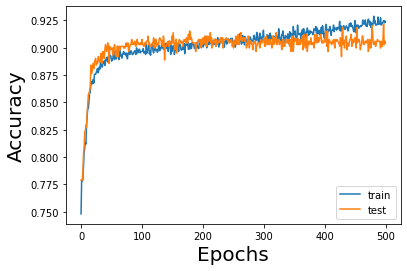

In [30]:
# Plotting train and test accuracy
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.plot(history_4.history["accuracy"], label="train")
plt.plot(history_4.history["val_accuracy"], label="test")

plt.legend()
plt.show()

# Q5) Training a 4-layer neural network

This question asks us to build a 4-layered neural network, with the following specifications
-	2 hidden layers with 10 neurons each
-	Batch size of 32
-	A weight decay parameter 10<sup>-6</sup>

In [31]:
# Define and train the model
q5_model = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-6))),
            Dense(units=3, activation="softmax")
        ])
q5_model.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
history_5 = q5_model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=32, epochs=EPOCHS, verbose=0)

print(f"Testing accuracy: {history_5.history['val_accuracy'][EPOCHS-1]}")

Testing accuracy: 0.9106582999229431


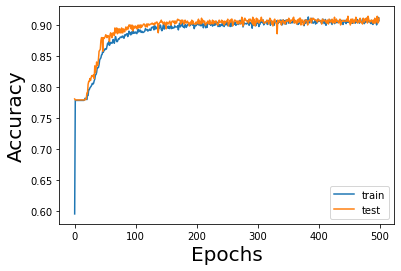

In [32]:
# Plotting train and test accuracy
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.plot(history_5.history["accuracy"], label="train")
plt.plot(history_5.history["val_accuracy"], label="test")

plt.legend()
plt.show()

It can be noted that the test accuracy of the 4-layered neural network is more than that of the 3 -layered network we managed to find in Question 4. This is because increasing the number of hidden layers increase thes the ability of the neural network to learn more complex functions and thus more complex characteristics of the dataset.

Testing accuracy: 0.9106582999229431


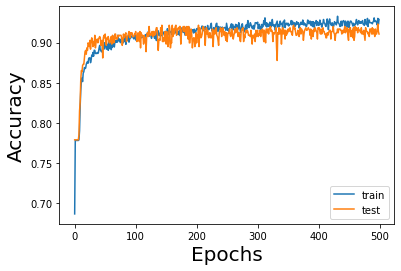

In [33]:
# Define and train the model
q5_model_extra = Sequential([
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-3))),
            Dense(units=10, activation="relu", kernel_regularizer=l2(10**(-3))),
            Dense(units=3, activation="softmax")
        ])
q5_model_extra.compile(optimizer=OPTIMIZER, loss=LOSS_TYPE, metrics=METRICS)
history_5_extra = q5_model_extra.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=8, epochs=EPOCHS, verbose=0)

print(f"Testing accuracy: {history_5_extra.history['val_accuracy'][EPOCHS-1]}")

# Plotting train and test accuracy
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.plot(history_5_extra.history["accuracy"], label="train")
plt.plot(history_5_extra.history["val_accuracy"], label="test")

plt.legend()
plt.show()



As can be seen, the testing accuracy of the optimal 4-layered network (0.911) is greater than the testing accuracy of the non-optimal 4-layered network (0.904). This indicates how important it is to train your network with optimal parameters.